# SR Example

First be sure the notebook is running with GPU.

Runtime -> Change Runtime Type -> GPU


***Le code fourni au départ est celui pour faire la Super Résolution***

# Charger les bibliothèques

In [5]:
# Colab only
# download and install Pytorch

# ferdi 1

!pip install torch torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import math

# La Base de donnée

On a choisit de travailler avec CIFAR 10, des images RGB 32 par 32, avec 10 classes, 50000 données d'entrainement et 10000 données de test.


On a voulu au départ travailler avec la base de donnée CELEBA, mais celle si étant trop lourde, avec plus de 2000 classes, on s'est retrouvé face aux problèmes suivants :
- devoir charger les données prend beaucoup de temps (+ de 200000 images)
- le téléchargement devait se faire sur un lien drive qui autorisait un download par 24h
- google collab enregistre le code mais vide les fichiers entre chaque session, on a donc tout perdu après les efforts

On a choisit une solutions sans drive, pytorch offre directement un accès à la base de donnée CIFAR10, qu'on peut donc download a chaque session sans difficulté et rapidement (car plus légère).


In [8]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print(trainset)

print(testset)


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


On utilise une transformation pour normaliser les images $I \in [0, 1]^3$ de CIFAR-10 de façon à avoir $I_{norm} \in [-1, 1]^3$ :

$
I_{norm} = \frac{I - \mu}{\sigma}
$

d'ou $\mu = 0.5$ et $\sigma = 0.5$

La normalisation vise à centrer les valeurs autour de zéro et à les mettre à l'échelle de manière à avoir une variance relativement uniforme. Cela peut aider à stabiliser et à accélérer l'entraînement du modèle, en particulier lorsque vous utilisez des méthodes d'optimisation sensibles à l'échelle des données.

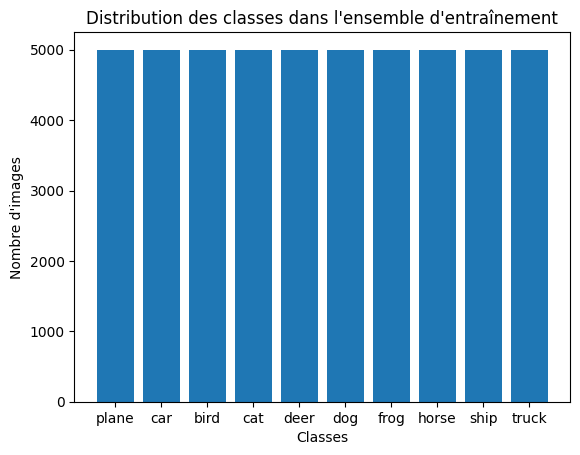

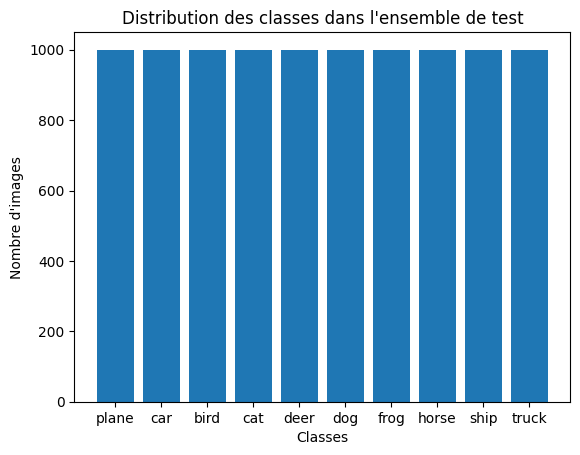

In [9]:
# Fonction pour afficher le nombre d'images par classe
def show_class_distribution(dataset, set_name):
    class_counts = [0] * len(classes)
    for _, label in dataset:
        class_counts[label] += 1

    fig, ax = plt.subplots()
    ax.bar(classes, class_counts)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Nombre d\'images')
    ax.set_title(f'Distribution des classes dans l\'ensemble {set_name}')
    plt.show()

# Afficher la distribution des classes dans l'ensemble d'entraînement
show_class_distribution(trainset, "d'entraînement")

# Afficher la distribution des classes dans l'ensemble de test
show_class_distribution(testset, "de test")

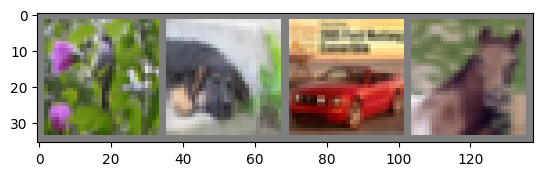

batch_size = 4 et dimension d'une image = torch.Size([3, 32, 32])
bird  dog   car   horse


In [10]:
# afficher un batch : (cette case peut être run autant de fois qu'on veut)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)



# show images
imshow(torchvision.utils.make_grid(images))
print(f"batch_size = {images.shape[0]} et dimension d'une image = {images.shape[1:]}")
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# Le modèle classique de pytorch

Dans cette partie, on va suivre le tutoriel de classification de pytorch (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).


## Création du Réseau :

Dans le tuto, on utilise la structure suivante :



In [11]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Optimization :

Dans le tuto, on utilise comme fonction de permet la Cross Entropy, et comme algorithme d'optimisation, la descente de  gradient stochastique.

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
n_epochs = 2

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.212
[1,  4000] loss: 1.882
[1,  6000] loss: 1.666
[1,  8000] loss: 1.574
[1, 10000] loss: 1.504
[1, 12000] loss: 1.458
[2,  2000] loss: 1.390
[2,  4000] loss: 1.370
[2,  6000] loss: 1.351
[2,  8000] loss: 1.348
[2, 10000] loss: 1.319
[2, 12000] loss: 1.305
Finished Training


In [14]:
# save the model
PATH = f"./cifar_net_tuto_n_epochs={n_epochs}.pth"
torch.save(net.state_dict(), PATH)

## Evaluation du modèle :

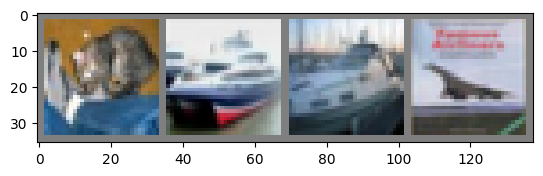

GroundTruth:  cat   ship  ship  plane
Predicted:  frog  ship  ship  plane


In [15]:
# tester le modele : (cette case peut être run autant de fois qu'on veut)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


In [16]:
# tester sur tout le test dataset :

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


Accuracy for class: plane is 40.7 %
Accuracy for class: car   is 68.0 %
Accuracy for class: bird  is 46.4 %
Accuracy for class: cat   is 27.7 %
Accuracy for class: deer  is 37.5 %
Accuracy for class: dog   is 31.9 %
Accuracy for class: frog  is 78.8 %
Accuracy for class: horse is 55.3 %
Accuracy for class: ship  is 78.5 %
Accuracy for class: truck is 72.6 %


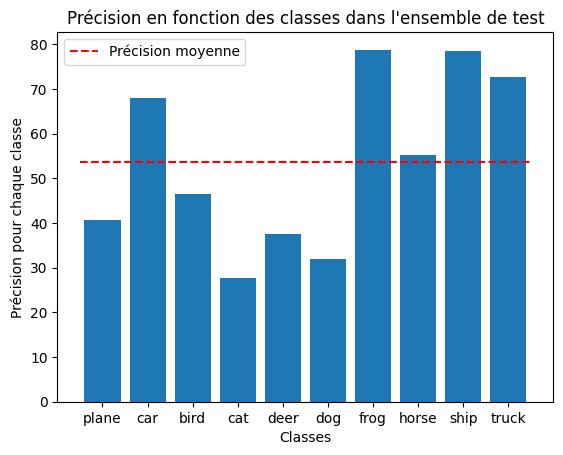

In [17]:
# précision en fonction des classes :

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class

noms_classe = []
precisions_classe = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    noms_classe.append(classname)
    precisions_classe.append(accuracy)
precision_moyenne = np.mean(precisions_classe)


fig, ax = plt.subplots()
ax.bar(noms_classe, precisions_classe)
ax.plot([-0.5,9.5], [precision_moyenne, precision_moyenne], '--r', label='Précision moyenne')
ax.set_xlabel('Classes')
ax.set_ylabel("Précision pour chaque classe")
ax.set_title("Précision en fonction des classes dans l'ensemble de test")
ax.legend()
plt.show()


# Le Modèle PARKHI

In [60]:
# create the neural network with Pytorch
class NetP(nn.Module):
  """NetP segmentation network."""

  def __init__(self, in_channels, out_channels):
    """Init NetP fields."""
    super(NetP, self).__init__()

    self.in_channels = in_channels

    S = 32

    self.conv11 = nn.Conv2d(in_channels, S, kernel_size=3, padding=1)
    self.bn11 = nn.BatchNorm2d(S)
    self.conv12 = nn.Conv2d(S, S, kernel_size=3, padding=1)
    self.bn12 = nn.BatchNorm2d(S)

    self.conv21 = nn.Conv2d(S, 2*S, kernel_size=3, padding=1)
    self.bn21 = nn.BatchNorm2d(2*S)
    self.conv22 = nn.Conv2d(2*S, 2*S, kernel_size=3, padding=1)
    self.bn22 = nn.BatchNorm2d(2*S)

    self.conv31 = nn.Conv2d(2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn31 = nn.BatchNorm2d(2*2*S)
    self.conv32 = nn.Conv2d(2*2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn32 = nn.BatchNorm2d(2*2*S)
    self.conv33 = nn.Conv2d(2*2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn33 = nn.BatchNorm2d(2*2*S)

    self.conv41 = nn.Conv2d(2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn41 = nn.BatchNorm2d(2*2*2*S)
    self.conv42 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn42 = nn.BatchNorm2d(2*2*2*S)
    self.conv43 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn43 = nn.BatchNorm2d(2*2*2*S)

    self.conv51 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn51 = nn.BatchNorm2d(2*2*2*S)
    self.conv52 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn52 = nn.BatchNorm2d(2*2*2*S)
    self.conv53 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn53 = nn.BatchNorm2d(2*2*2*S)


    # fully connected :

    self.fc6 = nn.Linear(in_features=2*2*2*S, out_features=4096)

    self.fc7 = nn.Linear(in_features=4096, out_features=4096)  

    self.fc8 = nn.Linear(in_features=4096, out_features=10)



  def forward(self, x, debug=False):
    if debug:
      print("entrée :", x.shape)
    # Stage 1
    x11 = F.relu(self.bn11(self.conv11(x)))
    if debug:
      print("stage 1 conv1 :", x11.shape)
    x12 = F.relu(self.bn12(self.conv12(x11)))
    if debug:
      print("stage 1 conv2 :", x12.shape)
    x1p = F.max_pool2d(x12, kernel_size=2, stride=2)
    if debug:
      print("stage 1 maxpool :", x1p.shape)
    # Stage 2
    x21 = F.relu(self.bn21(self.conv21(x1p)))
    if debug:
      print("stage 2 conv1 :", x21.shape)
    x22 = F.relu(self.bn22(self.conv22(x21)))
    if debug:
      print("stage 2 conv2 :", x22.shape)
    x2p = F.max_pool2d(x22, kernel_size=2, stride=2)
    if debug:
      print("stage 2 maxpool :", x2p.shape)
    # Stage 3
    x31 = F.relu(self.bn31(self.conv31(x2p)))
    if debug:
      print("stage 3 conv1 :", x31.shape)
    x32 = F.relu(self.bn32(self.conv32(x31)))
    if debug:
      print("stage 3 conv2 :", x32.shape)
    x33 = F.relu(self.bn33(self.conv33(x32)))
    if debug:
      print("stage 3 conv3 :", x33.shape)
    x3p = F.max_pool2d(x33, kernel_size=2, stride=2)
    if debug:
      print("stage 3 maxpool :", x3p.shape)
    # Stage 4
    x41 = F.relu(self.bn41(self.conv41(x3p)))
    if debug:
      print("stage 4 conv1 :", x41.shape)
    x42 = F.relu(self.bn42(self.conv42(x41)))
    if debug:
      print("stage 4 conv2 :", x42.shape)
    x43 = F.relu(self.bn43(self.conv43(x42)))
    if debug:
      print("stage 4 conv3 :", x43.shape)
    x4p = F.max_pool2d(x43, kernel_size=2, stride=2)
    if debug:
      print("stage 4 maxpool :", x4p.shape)
    # Stage 5
    x51 = F.relu(self.bn51(self.conv51(x4p)))
    if debug:
      print("stage 5 conv1 :", x51.shape)
    x52 = F.relu(self.bn52(self.conv52(x51)))
    if debug:
      print("stage 5 conv2 :", x52.shape)
    x53 = F.relu(self.bn53(self.conv53(x52)))
    if debug:
      print("stage 5 conv3 :", x53.shape)
    x5p = F.max_pool2d(x53, kernel_size=2, stride=2)
    if debug:
      print("stage 5 maxpool :", x5p.shape)
    #x5p.view(-1)
    x5p = torch.flatten(x5p, 1)
    if debug:
      print("stage 5 flatten :", x5p.shape)
    # Stage 6
    x6 = F.relu(self.fc6(x5p))
    if debug:
      print("stage 6 :", x6.shape)
     # Stage 7
    x7 = F.relu(self.fc7(x6))
    if debug:
      print("stage 7 :", x7.shape)
    # Stage 8
    x8 = F.relu(self.fc8(x7))
    if debug:
      print("stage 8 :", x8.shape)

      #x8 = F.softmax(x8)
      ### Modification to Unet for SR
      #y = self.upconv0(x8)

    return x8


In [61]:
# actual network creation
net = NetP(3,3)
net.cuda() # go GPU

NetP(
  (conv11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn32): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [62]:
import torch.optim

# create the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = F.mse_loss # ça marche pas ici parce que il faut criterion(outputs, labels) avec outputs et labels de meme size (pq ??)
criterion = nn.CrossEntropyLoss()

In [63]:
# # Epoch loops (the number of times we see the training dataset)
# for i in range(1000):

#   for j in range(1): # iterate over the dataset (here one single image, should be more)

#     # forward pass, compute the output of the network
#     outputs = net(inputs)

#     # compute the error (here mean square error)
#     loss = F.mse_loss(outputs, image)
#     optimizer.zero_grad()
#     loss.backward()



n_epochs = 2

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')



[1,  2000] loss: 2.305
[1,  4000] loss: 2.303
[1,  6000] loss: 2.303
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.303
[2,  2000] loss: 2.303
[2,  4000] loss: 2.303
[2,  6000] loss: 2.303
[2,  8000] loss: 2.303
[2, 10000] loss: 2.303
[2, 12000] loss: 2.303
Finished Training


In [64]:
# save the model
PATH = f"./cifar_net_parkhi_n_epochs={n_epochs}.pth"
torch.save(net.state_dict(), PATH)

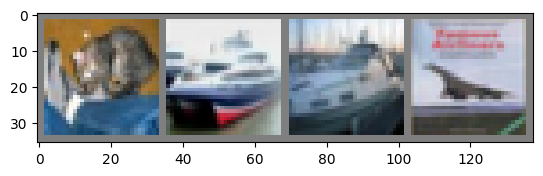

GroundTruth:  cat   ship  ship  plane
Predicted:  plane plane plane plane


In [73]:
# tester le modele : (cette case peut être run autant de fois qu'on veut)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


net = NetP(3,3)
net.load_state_dict(torch.load(PATH))
#net.cuda()

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


In [74]:
# tester sur tout le test dataset :

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %
